<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/jax-cosmo-paper/blob/master/notebooks/DES_Y1_3x2pt_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Illustration of JAX-cosmo on a DES Y1-like analysis

In [1]:
# In this notebook we fix cosmo and nuissance parameters, only vary late-bin parameters
# the bins can be easily set

# Need to change core code because: 
# TracerIntegerConversionError: The __index__() method was called on traced array with shape float32[].
# The error occurred while tracing the function mu at /tmp/ipykernel_514332/2511361142.py:4 for jit. This concrete value was not available in Python because it depends on the value of the argument params.
# See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerIntegerConversionError

%pylab inline
import sys
sys.path.append('/global/homes/k/kunhaoz/des/projects/jax_cosmo_late_mod/') #common system
import os
import jax
import jax.numpy as np
import jax_cosmo as jc
import numpy as onp

os.environ["CUDA_VISIBLE_DEVICES"]="0"

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
print(onp.geomspace(0.025, 0.8, 5+1))

print(np.logspace(-2, 0, 5+1))

[0.025 0.05  0.1   0.2   0.4   0.8  ]


I0000 00:00:1704575386.470946 1601948 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


[0.01       0.02511886 0.06309573 0.15848935 0.39810717 1.        ]


## Retrieving  the nz data

In [3]:
# Let's grab the data file
from astropy.io import fits
if not os.path.isfile('2pt_NG_mcal_1110.fits'):
    !wget http://desdr-server.ncsa.illinois.edu/despublic/y1a1_files/chains/2pt_NG_mcal_1110.fits

nz_source=fits.getdata('2pt_NG_mcal_1110.fits', 6)
nz_lens=fits.getdata('2pt_NG_mcal_1110.fits', 7)

Text(0.5, 0, 'z')

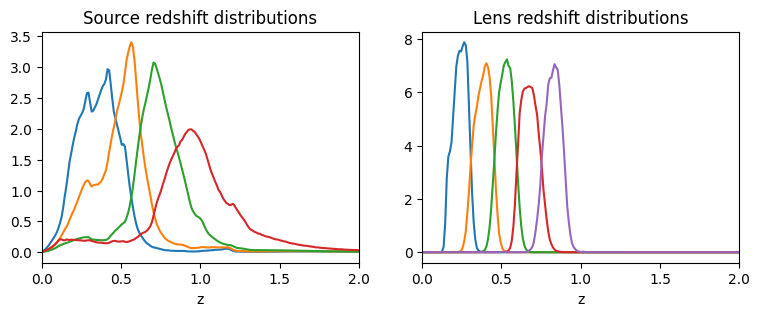

In [4]:
# Let's plot the NZs
figure(figsize=(9,3))
subplot(121)
plot(nz_source['Z_MID'], nz_source['BIN1'])
plot(nz_source['Z_MID'], nz_source['BIN2'])
plot(nz_source['Z_MID'], nz_source['BIN3'])
plot(nz_source['Z_MID'], nz_source['BIN4'])
xlim(0,2);
xlabel('z')
title('Source redshift distributions')
subplot(122)
plot(nz_lens['Z_MID'], nz_lens['BIN1'])
plot(nz_lens['Z_MID'], nz_lens['BIN2'])
plot(nz_lens['Z_MID'], nz_lens['BIN3'])
plot(nz_lens['Z_MID'], nz_lens['BIN4'])
plot(nz_lens['Z_MID'], nz_lens['BIN5'])
xlim(0,2);
title('Lens redshift distributions');
xlabel('z')

In [5]:
# Now let's try to build the equivalent with jax-cosmo

# This is the effective number of sources from the cosmic shear paper
neff_s = [1.47, 1.46, 1.50, 0.73]

nzs_s = [jc.redshift.kde_nz(nz_source['Z_MID'].astype('float32'),
                            nz_source['BIN%d'%i].astype('float32'), 
                            bw=0.01,
                            gals_per_arcmin2=neff_s[i-1])
           for i in range(1,5)]

nzs_l = [jc.redshift.kde_nz(nz_lens['Z_MID'].astype('float32'),
                              nz_lens['BIN%d'%i].astype('float32'), bw=0.01)
           for i in range(1,6)]

(0.0, 1.0)

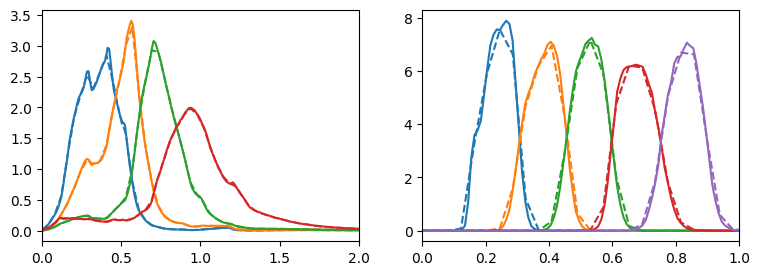

In [6]:
z = linspace(0,2)
figure(figsize=(9,3))
subplot(121)

for i in range(4):
    plot(nz_source['Z_MID'], nz_source['BIN%d'%(i+1)], color='C%d'%i)
    plot(z, nzs_s[i](z), '--', color='C%d'%i)

xlim(0,2)
subplot(122)

for i in range(5):
    plot(nz_lens['Z_MID'], nz_lens['BIN%d'%(i+1)], color='C%d'%i)
    plot(z, nzs_l[i](z), '--', color='C%d'%i)
xlim(0,1)

##  Let's build  a model for C_ell

In [7]:
# Specify range and spacing of bins; should be static variables

_z_bin = onp.array([0.0,   1.0, 5])
_k_bin = onp.array([0.025, 0.8, 5]) # First two entries are powers of 10; eg, 10^(-2)

# _k_bin = onp.array([-2, 0, 5]) 

# First, let's define a function to go to and from a 1d parameter vector
def get_params_vec(cosmo):
    N_zbin      = cosmo.z_bin[2]
    zbin_values = np.array([cosmo.a_late[i] for i in range(0, int(N_zbin))])
    N_kbin      = cosmo.z_bin[2]
    kbin_values = np.array([cosmo.b_late[i] for i in range(0, int(N_kbin))])
    

    return np.append(zbin_values, kbin_values)
    
def unpack_params_vec(params):
    # Retrieve cosmology
    # !!NOTE!! This is not automatic because of possible variation of cosmo-parameters; be careful with index...
    zmod = np.array([params[i] for i in range(int(_z_bin[2]))])
    kmod = np.array([params[i] for i in range(int(_z_bin[2]), int(_z_bin[2]) + int(_k_bin[2])) ])
    cosmo = jc.Cosmology(sigma8=0.8159, Omega_c=0.2589, Omega_b=0.04860,
                         h=0.6774, n_s=0.9667, w0=-1.0, # Fix w0=-1
                         Omega_k=0., wa=0.,
                         a_late=zmod, z_mod_form="bin_custom", z_bin=_z_bin,
                         b_late=kmod, k_mod_form="bin_custom", k_bin=_k_bin)
    m1,m2,m3,m4 = [0.0,0.0,0.0,0.0]
    dz1,dz2,dz3,dz4 =  [0.0,0.0,0.0,0.0]
    A = 0.0 # KZ: completely turn off IA for now
    eta = 0.0
    bias = [1.2, 1.4, 1.6, 1.8, 2.0]
    return cosmo, [m1,m2,m3,m4], [dz1,dz2,dz3,dz4], [A, eta], bias



In [8]:
print([i for i in range(int(_z_bin[2]))])
print([i for i in range(int(_z_bin[2]), int(_z_bin[2]) + int(_k_bin[2])) ])

[0, 1, 2, 3, 4]
[5, 6, 7, 8, 9]


In [9]:
# Define some ell range
ell = np.logspace(1, 3)

@jax.jit
def mu(params):
    # First unpack parameter vector
    cosmo, m, dz, (A, eta), bias = unpack_params_vec(params) 

    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]

    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    # Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in bias] 

    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m)]
    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl

In [10]:
# Let's try it out
tmpa = np.array([0. for i in range(int(_z_bin[2]))])
print(tmpa)
tmpb = np.array([0. for i in range(int(_k_bin[2]))])
print(tmpb)
fid_cosmo = jc.Cosmology(sigma8=0.801,
                          Omega_c=0.2545,
                          Omega_b=0.0485,
                          h=0.682,
                          n_s=0.971,
                          w0=-1., Omega_k=0., wa=0.,
                          a_late=tmpa, z_mod_form="bin_custom", z_bin=_z_bin,
                          b_late=tmpb, k_mod_form="bin_custom", k_bin=_k_bin,
                        )

fid_params = get_params_vec(fid_cosmo)

print(fid_params)

[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/global/homes/k/kunhaoz/miniconda3/envs/jax-gpu/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


[1.0347323e-08 9.8122133e-09 9.2553014e-09 8.6847596e-09 8.1096339e-09
 7.5367170e-09 6.9734258e-09 6.4251955e-09 5.8971139e-09 5.3929665e-09
 4.9157007e-09 4.4665978e-09 4.0460986e-09 3.6539753e-09 3.2897758e-09
 2.9526528e-09 2.6417308e-09 2.3565752e-09 2.0968078e-09 1.8615263e-09
 1.6496560e-09 1.4604190e-09 1.2926555e-09 1.1446907e-09 1.0146008e-09
 9.0025681e-10 7.9981055e-10 7.1157308e-10 6.3394157e-10 5.6570232e-10
 5.0569737e-10 4.5281104e-10 4.0605597e-10 3.6459383e-10 3.2768555e-10
 2.9470895e-10 2.6512853e-10 2.3849162e-10 2.1442104e-10 1.9260209e-10
 1.7277360e-10 1.5472040e-10 1.3826493e-10 1.2325944e-10 1.0958053e-10
 9.7124399e-11 8.5801352e-11 7.5532629e-11 6.6247362e-11 5.7880103e-11]


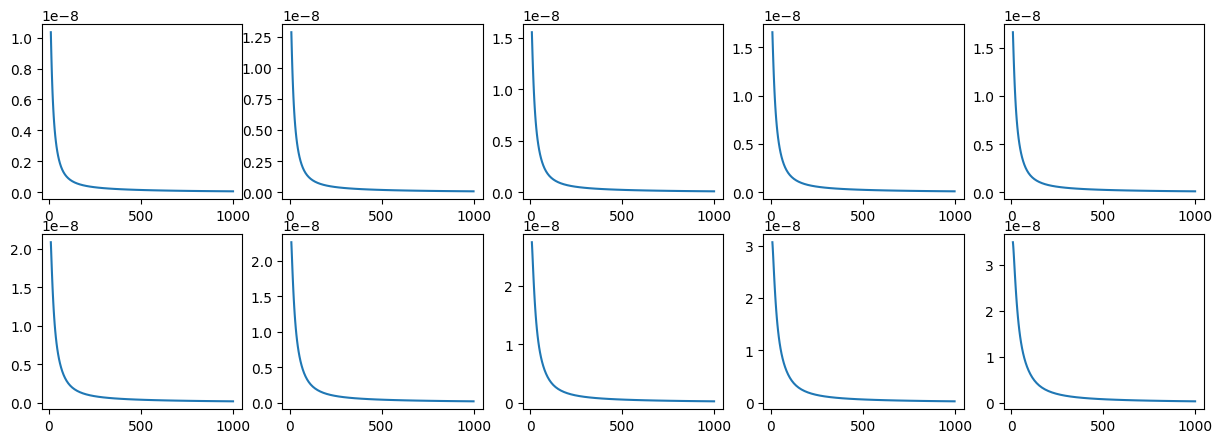

In [11]:
cl_cs = mu(fid_params)

print(cl_cs[0])

fig, axes = plt.subplots(2, 5, figsize=(15, 5))
for i in range(2):
    for j in range(5):
        ax = axes[i][j]
        ax.plot(ell, cl_cs[i*5 + j])


In [12]:
## Building a Fisher matrix, we just need the covarianc
@jax.jit
def cov(params):
    
    cl_signal = mu(params)
    
    # First unpack parameter vector
    cosmo, m, dz, (A, eta), bias = unpack_params_vec(params) 
    
    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]
    
    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m)]
    
    cl_noise = jc.angular_cl.noise_cl(ell, probes)
    
    cov = jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky=0.25, 
                                               sparse=False)
    
    return cov

In [13]:
C = cov(fid_params)

print(C.shape)

# print(C[0])

print(onp.where(C[0]!=0))


print(C[0][onp.where(C[0]!=0)])

(500, 500)
(array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450]),)
[9.98027489e-17 7.98204939e-17 9.64891891e-17 1.02763969e-16
 6.38390336e-17 7.71703660e-17 8.21888179e-17 9.32856377e-17
 9.93520877e-17 1.05813056e-16]


In [14]:
jacobian = jax.jit(jax.jacfwd(lambda p: mu(p).flatten()))

In [15]:
j = jacobian(fid_params)

In [16]:
%timeit jacobian(fid_params).block_until_ready()

14.4 ms ± 27.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
import scipy

def symmetrized_matrix(U):
    u"""Return a new matrix like `U`, but with upper-triangle elements copied to lower-triangle ones."""
    M = U.copy()
    inds = onp.triu_indices_from(M,k=1)
    M[(inds[1], inds[0])] = M[inds]
    return M



def symmetric_positive_definite_inverse(M):
    u"""Compute the inverse of a symmetric positive definite matrix `M`.

    A :class:`ValueError` will be thrown if the computation cannot be
    completed.

    """
    import scipy.linalg
    U,status = scipy.linalg.lapack.dpotrf(M)
    if status != 0:
        raise ValueError("Non-symmetric positive definite matrix")
    M,status = scipy.linalg.lapack.dpotri(U)
    if status != 0:
        raise ValueError("Error in Cholesky factorization")
    M = symmetrized_matrix(M)
    return M

In [18]:
j64 = onp.array(j).astype(onp.float64)
C64 = onp.array(C).astype(onp.float64)

In [19]:
# And we get the fisher matrix from the jacobian and covariance
CC = symmetric_positive_definite_inverse(C64)
F = onp.einsum('ia,ij,jb->ab', j64, CC, j64)
F = 0.5*(F + F.T)

print(F.shape)

(10, 10)


In [20]:
def is_symmetric(X):
    return onp.all(X == X.T)

is_symmetric(F)

True

In [21]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos, i, j, nstd=1., ax=None, resize=False, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  # Extracts the block we are interested in
  cov = cov[:,[i,j]][[i,j],:]
  vals, vecs = eigsorted(cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * sqrt(vals)
  xy = [pos[i], pos[j]]
  ellip = Ellipse(xy=xy, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  if resize:
    sz = max(width, height)
    s1 = 1.5*nstd*sigma_marg(i)
    s2 = 1.5*nstd*sigma_marg(j)
    ax.set_xlim(pos[i] - s1, pos[i] + s1)
    ax.set_ylim(pos[j] - s2, pos[j] + s2)
  plt.draw()
  return ellip

In [22]:
fid_params

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [23]:
print(F)

[[7.25717295e+03 9.13729109e+02 5.90491189e+02 1.89701151e+02
  3.81265742e+01 3.28833458e+02 1.13424943e+03 2.84521984e+03
  4.26130040e+03 2.06616002e+03]
 [9.13729109e+02 3.44721291e+02 1.99149450e+02 5.63230184e+01
  9.89609555e+00 9.59752919e+01 2.55119074e+02 5.33501878e+02
  9.23314016e+02 2.28702334e+02]
 [5.90491189e+02 1.99149450e+02 1.66897350e+02 5.90553895e+01
  1.09578943e+01 6.69432276e+01 1.66873064e+02 3.48427426e+02
  5.91138080e+02 2.07861869e+02]
 [1.89701151e+02 5.63230184e+01 5.90553895e+01 2.62556943e+01
  5.56851643e+00 2.26564791e+01 5.41407217e+01 1.12564763e+02
  1.89017730e+02 7.80296944e+01]
 [3.81265742e+01 9.89609555e+00 1.09578943e+01 5.56851643e+00
  1.31902403e+00 4.10773230e+00 1.02163711e+01 2.19585943e+01
  3.66908874e+01 1.60454748e+01]
 [3.28833458e+02 9.59752919e+01 6.69432276e+01 2.26564791e+01
  4.10773230e+00 1.24489590e+02 8.95725124e+01 1.15084000e+02
  1.81826932e+02 8.29073043e+01]
 [1.13424943e+03 2.55119074e+02 1.66873064e+02 5.41407217e

In [24]:
# names = ['a_late_1','a_late_2','a_late_3','a_late_4','a_late_5', 'a_late_6','a_late_7','a_late_8','a_late_9','a_late_10',
#          'b_late_1','b_late_2','b_late_3','b_late_4','b_late_5', 'b_late_6','b_late_7','b_late_8','b_late_9','b_late_10'
#         ]

# nparam = len(names)
# nplot = nparam
# fig, axes = plt.subplots(nplot, nplot, figsize=(2*nplot,2*nplot), sharex=False, sharey=False)
# pmin = [-0.1 for i in range(20)]
# pmax = [0.1 for i in range(20)]
# for i, name1 in enumerate(names[:]):
#     for j, name2 in enumerate(names[:]):
#         if i>=nplot or j >= nplot:
#             continue
#         ax = axes[i, j]
#         if i < j:
#             fig.delaxes(ax)
#             continue
#         if i == j:
#             ax.set_xlim(pmin[i], pmax[i])
#         else:
#             plot_contours(F, fid_params, j, i, ax=ax, edgecolor='r', facecolor='none')
#             ax.set_xlim(pmin[j], pmax[j])
#             ax.set_ylim(pmin[i], pmax[i])
#         if j == 0:
#             ax.set_ylabel(name1)
#         else:
#             ax.get_yaxis().set_visible(False)

#         if i == nplot-1:
#             ax.set_xlabel(name2)
#         else:
#             ax.get_xaxis().set_visible(False)
# subplots_adjust(wspace=0.05)
# subplots_adjust(hspace=0.05)

In [25]:
cov_param = symmetric_positive_definite_inverse(F)
print("is symmetric",is_symmetric(cov_param))

print("is hermitian", scipy.linalg.ishermitian(cov_param))

is symmetric True
is hermitian True


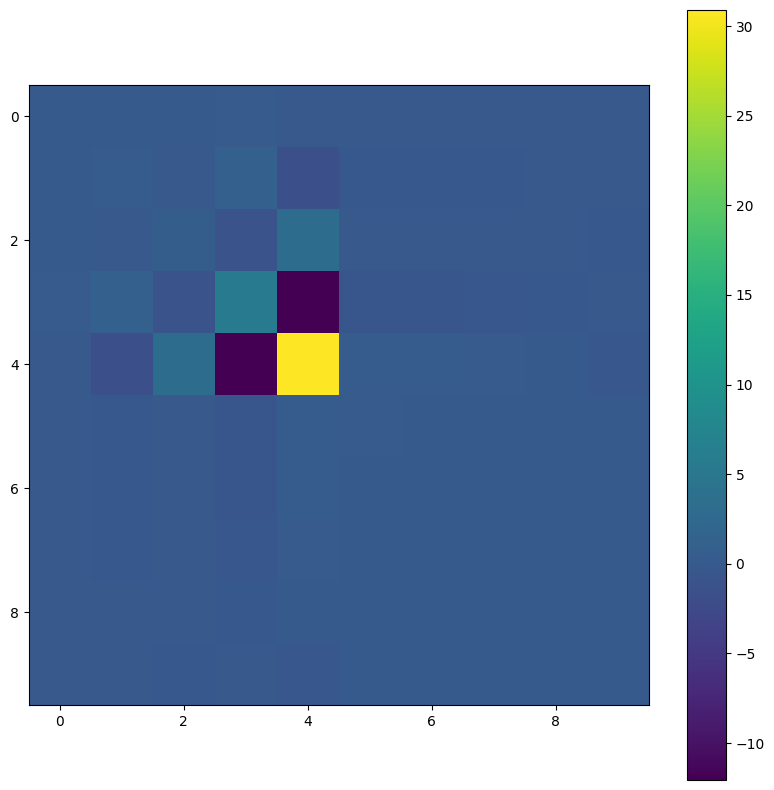

In [26]:
figure(figsize=(10,10))
# Here we convert the covariance matrix from sparse to dense reprensentation
# for plotting
imshow(cov_param);
plt.colorbar()

In [27]:
eig_vals, eig_vecs = np.linalg.eigh(cov_param)

In [28]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=False)

# Confirm that the list is correctly sorted by ascending eigenvalues
print('Eigenvalues in ascending order:')
for i in eig_pairs:
    print(i[0])
    
# Select first two PC
PC1 = onp.array(eig_pairs[0][1])
PC2 = onp.array(eig_pairs[1][1])
PC3 = onp.array(eig_pairs[2][1])

Eigenvalues in ascending order:
8.113426e-05
0.0010038926
0.003959607
0.008207784
0.009868305
0.017804094
0.10231867
0.32791302
1.7867795
36.184605


In [29]:
print(PC1)

tmp=0
for i in range(len(PC1)):
    tmp = tmp + PC1[i]**2
print(tmp)

[-0.75012165 -0.11852434 -0.0776094  -0.02509432 -0.00495309 -0.0344899
 -0.12469793 -0.31838974 -0.5019656  -0.21566728]
1.0000009655031359


Text(0, 0.5, 'k bin')

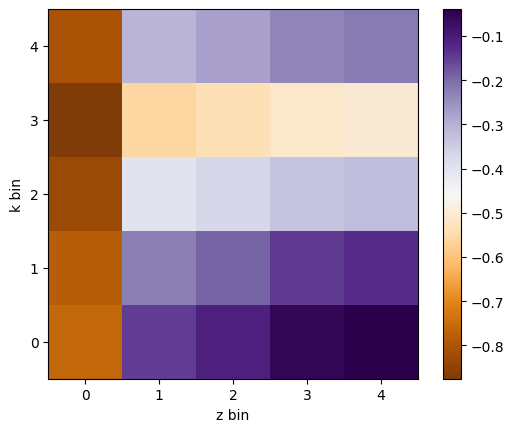

In [30]:
bins=5

grid_1 = onp.zeros((bins,bins))

for i in range(bins):
    for j in range(bins):
        grid_1[i][j] = (1 + PC1[i]) * (1 + PC1[j+bins])

grid_1 = grid_1.T
grid_1 = grid_1 - 1 # "Normalization"
imshow(grid_1, origin = 'lower', cmap='PuOr')
plt.colorbar()
plt.xlabel("z bin")
plt.ylabel("k bin")

Text(0, 0.5, 'k bin')

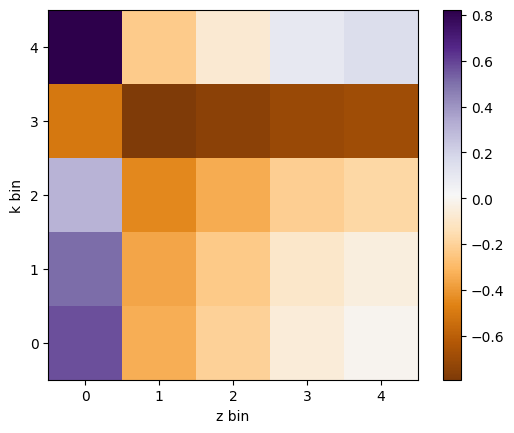

In [31]:
bins=5

grid_2 = onp.zeros((bins,bins))

for i in range(bins):
    for j in range(bins):
        grid_2[i][j] = (1 + PC2[i]) * (1 + PC2[j+bins])
        
grid_2 = grid_2.T
grid_2 = grid_2 - 1 # "Normalization"
imshow(grid_2, origin = 'lower', cmap='PuOr')
plt.colorbar()
plt.xlabel("z bin")
plt.ylabel("k bin")

Text(0, 0.5, 'k bin')

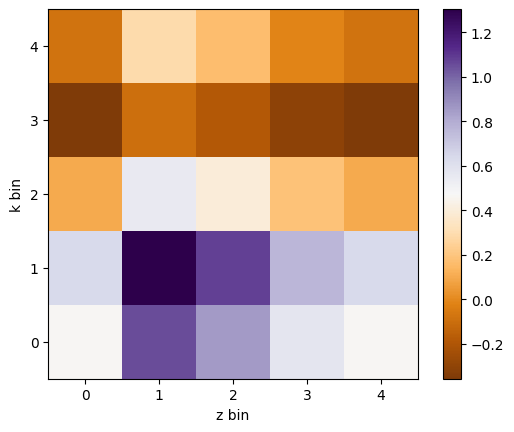

In [32]:
bins=5

grid_3 = onp.zeros((bins,bins))

for i in range(bins):
    for j in range(bins):
        grid_3[i][j] = (1 + PC3[i]) * (1 + PC3[j+bins])

grid_3 = grid_3.T
grid_3 = grid_3 - 1 # "Normalization"
imshow(grid_3, origin = 'lower', cmap='PuOr')
plt.colorbar()
plt.xlabel("z bin")
plt.ylabel("k bin")

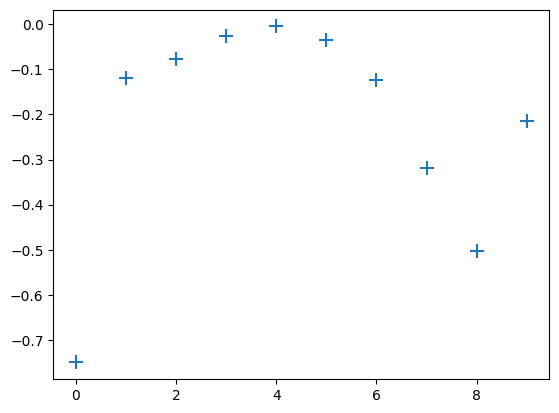

In [33]:
plt.scatter(np.arange(0,10),PC1, marker='+', s=100)

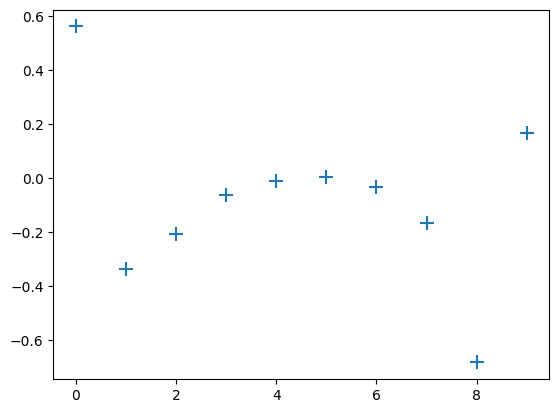

In [34]:
plt.scatter(np.arange(0,10),PC2, marker='+', s=100)

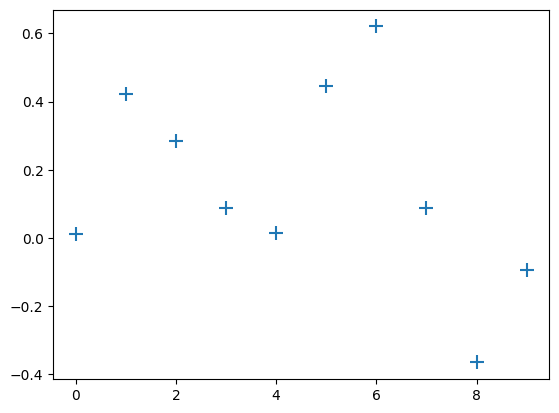

In [35]:
 plt.scatter(np.arange(0,10),PC3, marker='+', s=100)